<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_4_Genetic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Source: https://github.com/DEAP/deap/blob/master/examples/ga/onemax_numpy.py

DEAP is free software: you can redistribute it and/or modify
   it under the terms of the GNU Lesser General Public License as
   published by the Free Software Foundation, either version 3 of
   the License, or (at your option) any later version.

   DEAP is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; without even the implied warranty of
   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
   GNU Lesser General Public License for more details.
   You should have received a copy of the GNU Lesser General Public
   License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

In [ ]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 163kB 13.8MB/s 


In [ ]:
#@title Imports
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [ ]:
#@title Protected Division to avoid errors
random.seed(64)
def protectedDiv(left, right):
    with np.errstate(divide='ignore',invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

In [ ]:
#@title Create Set of Operators
pset = gp.PrimitiveSet("MAIN", 4)
pset.addPrimitive(np.add, 2, name="vadd")
pset.addPrimitive(np.subtract, 2, name="vsub")
pset.addPrimitive(np.multiply, 2, name="vmul")
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(np.negative, 1, name="vneg")
pset.addPrimitive(np.cos, 1, name="vcos")
pset.addPrimitive(np.sin, 1, name="vsin")
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

pset.renameArguments(ARG0='x1')
pset.renameArguments(ARG1='x2')
pset.renameArguments(ARG2='x3')
pset.renameArguments(ARG3='x4')

In [ ]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [ ]:
#@title Open the Toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [ ]:
x = np.random.rand(4, 10000)
y = (x[3] + x[0]) / x[2] * x[1] 

(13, 506)


In [ ]:
#@title Define a Fitness/Evaluation Function
def evalSymbReg(individual):
    #tree = gp.PrimitiveTree(individual)
    #print(str(tree))

    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)    
    # Evaluate the sum of squared difference between the expression
    # and the real function values : x**4 + x**3 + x**2 + x 
    diff = np.sum((func(x[0],x[1],x[2],x[3]) - y)**2)    
    return diff,

In [ ]:
#@title Add Genetic Operators to Toolbox
toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [ ]:
#@title Code to Plot the Expression Tree
import matplotlib.pyplot as plt
import networkx as nx

def plot_expression(individual):
  options = {"node_size": 500, "alpha": 0.8}
  nodes, edges, labels = gp.graph(individual)

  g = nx.Graph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  
  pos = nx.spring_layout(g)  
  nx.draw_networkx_nodes(g, pos, **options)
  nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)
  nx.draw_networkx_labels(g, pos, labels, font_size=9, font_color='k')  
  plt.show()

In [ ]:
#@title Defining the Evolution Function
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None):  
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)    
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit  
            if fit[0] <= 1:
              print("Solved")
              done = True

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)
            plot_expression(halloffame[0])              

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)     

gen	nevals	avg        	std        	min   	max        
0  	30000 	5.65886e+09	3.06224e+11	127612	2.99887e+13


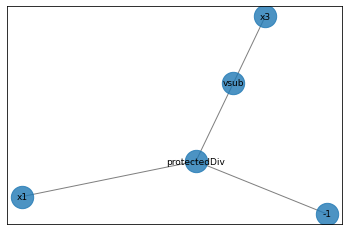

1  	16574 	9.64763e+08	1.38801e+11	125438	2.35652e+13


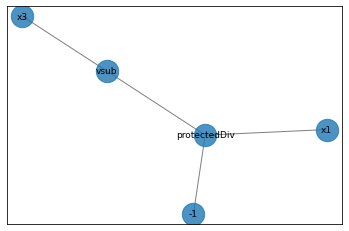

2  	16435 	4.71004e+09	4.82264e+11	125438	7.75632e+13


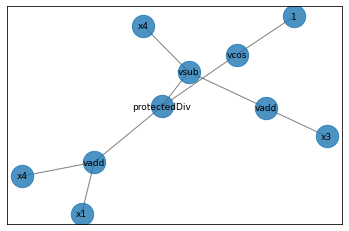

3  	16654 	1.30689e+09	1.75866e+11	104185	2.99887e+13


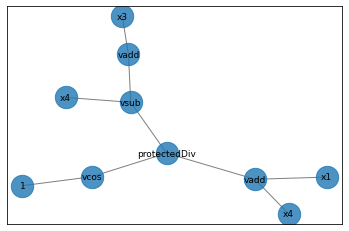

4  	16497 	1.2183e+08 	2.04546e+10	104185	3.54284e+12


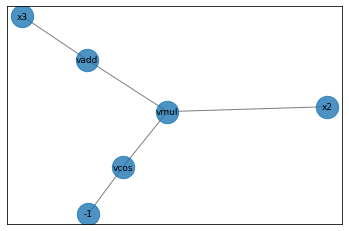

5  	16752 	1.25072e+08	2.04594e+10	102677	3.54279e+12


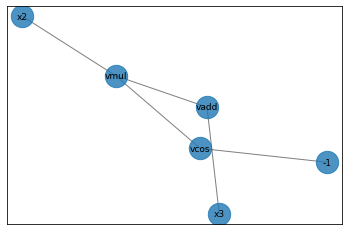

6  	16385 	9.25596e+08	1.37582e+11	102677	2.35595e+13


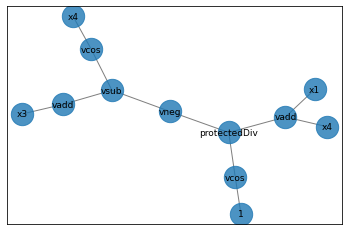

7  	16641 	2.93284e+08	3.54763e+10	97628.6	5.02066e+12


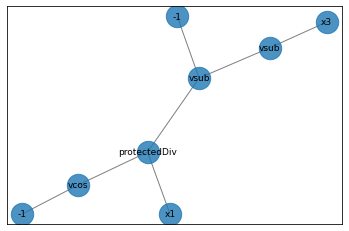

8  	16525 	1.55492e+07	1.8678e+09 	92840.4	3.22739e+11


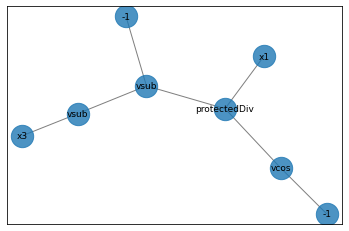

9  	16243 	4.87907e+08	4.3733e+10 	92840.4	4.76464e+12


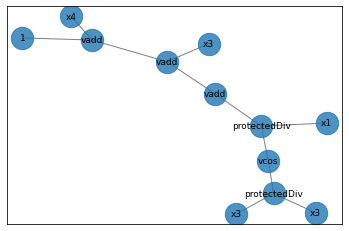

10 	16586 	1.52686e+10	1.90452e+12	92083.9	3.10066e+14


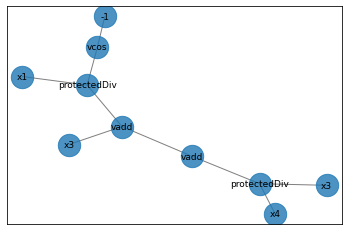

11 	16558 	1.745e+32  	3.02239e+34	91179.8	5.23501e+36


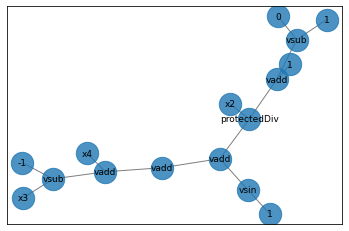

12 	16498 	9.98515e+11	1.72542e+14	90726.8	2.98856e+16


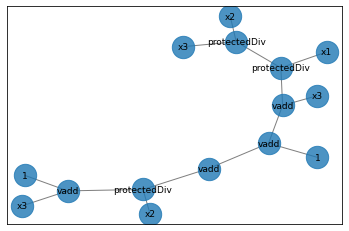

13 	16564 	1.8915e+32 	3.27611e+34	76662.7	5.67449e+36


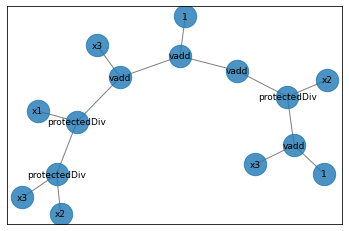

14 	16718 	1.8915e+32 	3.27611e+34	76662.7	5.67449e+36


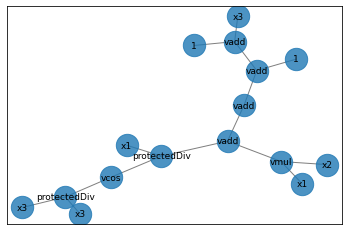

15 	16529 	1.8915e+32 	3.27611e+34	74953.2	5.67449e+36


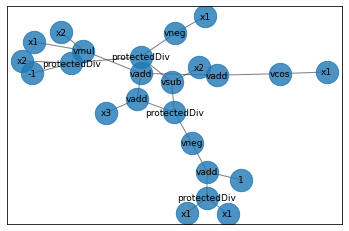

16 	16535 	2.61377e+32	3.5068e+34 	73307.3	5.67449e+36


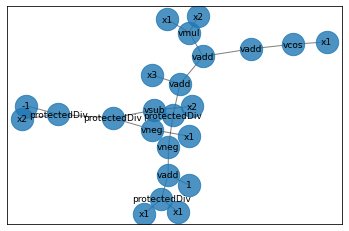

17 	16596 	3.63027e+12	5.70021e+14	73307.3	9.81809e+16


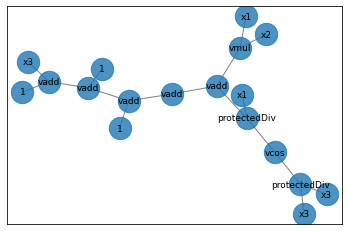

18 	16456 	3.0217e+32 	3.89516e+34	72217.8	6.0211e+36 


KeyboardInterrupt: ignored

In [ ]:
#@title Run the Evolution
pop = toolbox.population(n=30000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

eaSimple(pop, toolbox, 0.5, 0.1, 40, stats, halloffame=hof)

